<a href="https://colab.research.google.com/github/plusheart/NTHU_2025_GenAI/blob/main/Dict/w3_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**目標**


*   以 MNIST 手寫數字數據集進行生成對抗網路
*   分別使用 KL Loss 跟 BCE Loss



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# 設定超參數
batch_size = 64
z_dim = 100  # 生成器的隱藏向量維度
epochs = 20
lr = 0.0002

# DataSet: 手寫數字MNIST 數據集

In [ ]:
# MNIST 數據集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:10<00:00, 907kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]


# GAN

In [ ]:
# 生成器
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # MNIST 為 -1~1
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

In [ ]:
# 判別器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # BCE Loss 需要 Sigmoid 輸出
        )

    def forward(self, img):
        return self.model(img.view(-1, 28*28))

In [ ]:
# 訓練函數
def train_GAN(loss_type="BCE"):
    # 初始化模型
    generator = Generator(z_dim).cuda()
    discriminator = Discriminator().cuda()

    # 設定優化器
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # 設定 Loss function
    if loss_type == "BCE":
        criterion = nn.BCELoss()
    elif loss_type == "KL":
        criterion = nn.KLDivLoss(reduction='batchmean')
    elif loss_type == "KL_new":
        criterion = nn.KLDivLoss(reduction='batchmean')

    # 訓練過程
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.cuda()
            batch_size = real_imgs.size(0)

            # 標籤
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            # 訓練判別器
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, z_dim).cuda()
            fake_imgs = generator(z).detach()

            real_loss = criterion(discriminator(real_imgs), real_labels)
            fake_loss = criterion(discriminator(fake_imgs), fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # 訓練生成器
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, z_dim).cuda()
            fake_imgs = generator(z)

            if loss_type == "BCE":
                g_loss = criterion(discriminator(fake_imgs), real_labels)
            elif loss_type == "KL":
                g_loss = criterion(torch.log(discriminator(fake_imgs) + 1e-10), real_labels)
            elif loss_type == "KL_new":
                g_loss = criterion(torch.log(discriminator(fake_imgs) + 1e-10), real_labels)


            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

        # 每 5 個 epoch 可視化一次
        if (epoch + 1) % 5 == 0:
            visualize_results(generator, loss_type, epoch)

    return generator

# 每 10 個 Epoch，從生成器產生圖片

In [ ]:
# 生成圖片並可視化
def visualize_results(generator, loss_type, epoch):
    generator.eval()
    z = torch.randn(16, z_dim).cuda()
    fake_imgs = generator(z).cpu().detach().numpy()

    plt.figure(figsize=(5,5))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(fake_imgs[i].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"{loss_type} Loss - Epoch {epoch+1}")
    plt.show()
    generator.train()

# 使用Binary Cross Entropy Loss

In [ ]:
print("Training with BCE Loss...")

Training with BCE Loss...


In [ ]:
start_time1 = time.time()

Epoch [1/20] | D Loss: 0.6526 | G Loss: 2.6810
Epoch [2/20] | D Loss: 1.4775 | G Loss: 3.9800
Epoch [3/20] | D Loss: 0.3443 | G Loss: 3.9239
Epoch [4/20] | D Loss: 0.2183 | G Loss: 2.8084
Epoch [5/20] | D Loss: 0.5608 | G Loss: 5.2669


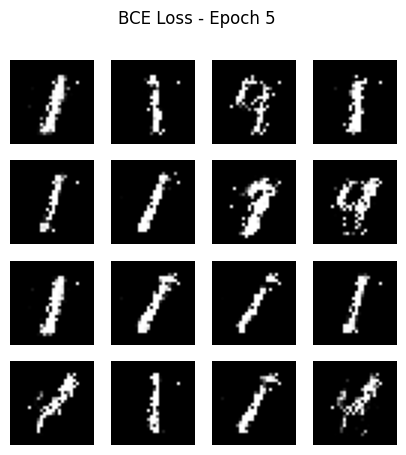

Epoch [6/20] | D Loss: 0.3373 | G Loss: 2.4708
Epoch [7/20] | D Loss: 0.4321 | G Loss: 3.2250
Epoch [8/20] | D Loss: 0.5349 | G Loss: 2.2754
Epoch [9/20] | D Loss: 0.7233 | G Loss: 1.6248
Epoch [10/20] | D Loss: 0.9668 | G Loss: 1.7998


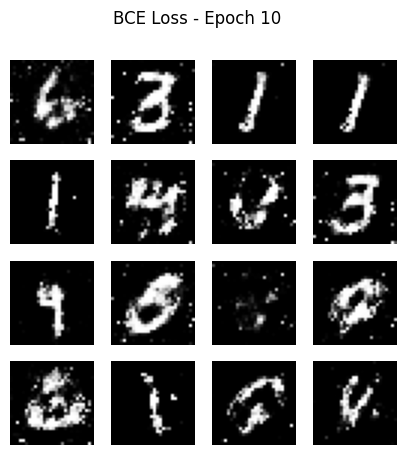

Epoch [11/20] | D Loss: 0.9506 | G Loss: 1.5685
Epoch [12/20] | D Loss: 0.8443 | G Loss: 2.0397
Epoch [13/20] | D Loss: 0.7050 | G Loss: 0.8288
Epoch [14/20] | D Loss: 0.9052 | G Loss: 1.4786
Epoch [15/20] | D Loss: 0.8039 | G Loss: 2.1814


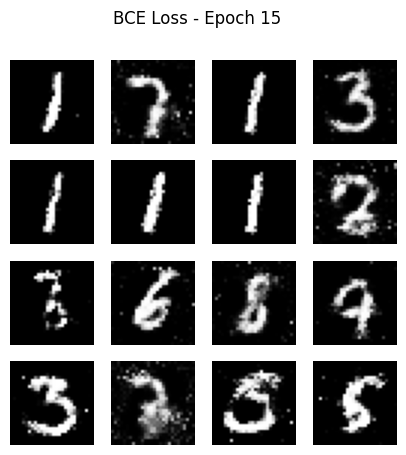

Epoch [16/20] | D Loss: 0.8386 | G Loss: 2.1331
Epoch [17/20] | D Loss: 0.9755 | G Loss: 1.0725
Epoch [18/20] | D Loss: 0.8018 | G Loss: 1.3038
Epoch [19/20] | D Loss: 0.8437 | G Loss: 1.5666
Epoch [20/20] | D Loss: 0.9349 | G Loss: 1.5544


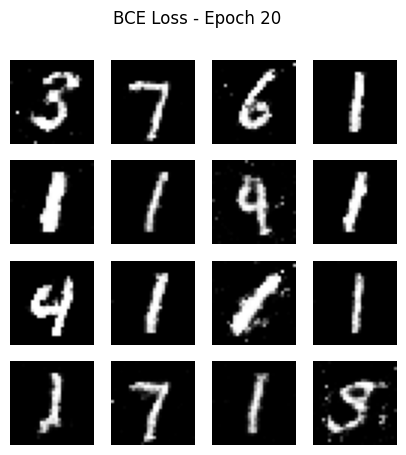

In [ ]:
generator_BCE = train_GAN(loss_type="BCE")

In [ ]:
end_time1 = time.time()
total_time1 = end_time1 - start_time1
print(f"⏳ 總花費時間: {total_time1:.2f} 秒")

⏳ 總花費時間: 340.21 秒


# 使用KL loss
*   遇到梯度消失問題


In [ ]:
print("Training with KL Loss...")

Training with KL Loss...


In [ ]:
start_time2 = time.time()

Epoch [1/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [2/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [3/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [4/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [5/20] | D Loss: -1.0000 | G Loss: 0.0000


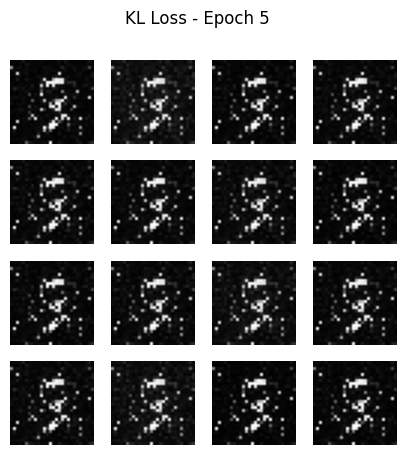

Epoch [6/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [7/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [8/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [9/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [10/20] | D Loss: -1.0000 | G Loss: 0.0000


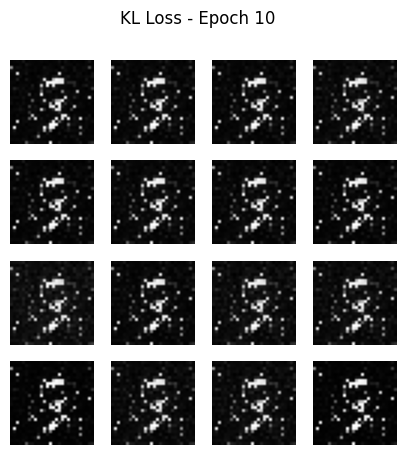

Epoch [11/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [12/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [13/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [14/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [15/20] | D Loss: -1.0000 | G Loss: 0.0000


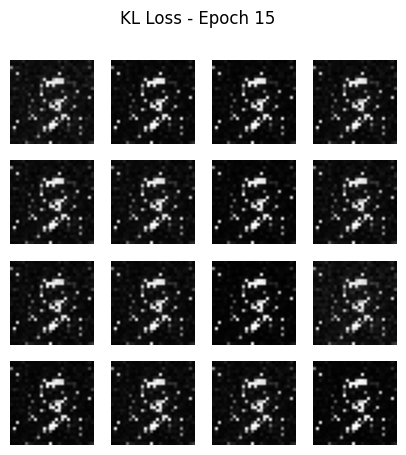

Epoch [16/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [17/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [18/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [19/20] | D Loss: -1.0000 | G Loss: 0.0000
Epoch [20/20] | D Loss: -1.0000 | G Loss: 0.0000


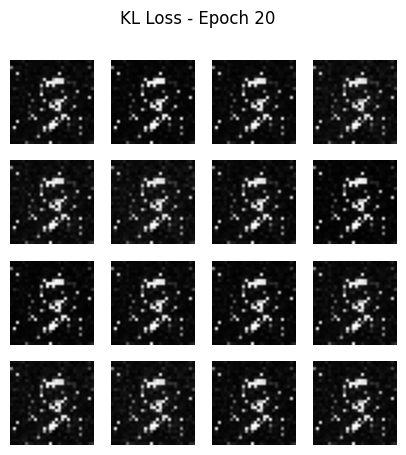

In [ ]:
generator_KL = train_GAN(loss_type="KL")

In [ ]:
end_time2 = time.time()
total_time2 = end_time2 - start_time2
print(f"⏳ 總花費時間: {total_time2:.2f} 秒")

⏳ 總花費時間: 343.97 秒
